# Image FFT Processing with Burn

This notebook demonstrates Fast Fourier Transform (FFT) operations on images using Burn's tensor FFT functionality. We'll explore:

1. Loading an image and converting to tensor
2. Applying 2D FFT to analyze frequency components
3. Manipulating frequency domain data
4. Applying inverse FFT to reconstruct images
5. Creating frequency domain filters (low-pass, high-pass)

TODO ; check all this 'fraais'

In [5]:
// Import necessary crates for FFT image processing
:dep image = "0.23"
:dep evcxr_image = "1.1"
:dep burn = {path = "../../crates/burn"}
:dep burn-ndarray = {path = "../../crates/burn-ndarray"}
:dep burn-vision = {path = "../../crates/burn-vision", features = ["export-tests"]}
:dep burn-cubecl = {path = "../../crates/burn-cubecl"}

use image::{DynamicImage, GenericImageView, ImageBuffer, Luma, Rgb};
use evcxr_image::ImageDisplay;
use burn_vision::tests::{load_test_image, save_test_image};
use burn_ndarray::{NdArray, NdArrayDevice};
use burn::tensor::Tensor;

type Backend = NdArray<f32>;
let device = NdArrayDevice::Cpu;

println!("✅ All dependencies loaded for FFT image processing!");

✅ All dependencies loaded for FFT image processing!


Original test image with frequency patterns created (128x128)


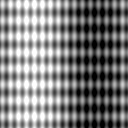

In [11]:
// Create a test image with some patterns for FFT analysis
let test_img = image::ImageBuffer::<image::Rgb<u8>, _>::from_fn(128, 128, |x, y| {
    // Create a pattern with both low and high frequency components
    let low_freq = ((x as f32 / 128.0 * 2.0 * std::f32::consts::PI).sin() * 0.3 + 0.5) * 255.0;
    let high_freq = ((x as f32 / 8.0 * 2.0 * std::f32::consts::PI).sin() * 0.2) * 255.0;
    let vertical_pattern = ((y as f32 / 16.0 * 2.0 * std::f32::consts::PI).sin() * 0.2) * 255.0;
    
    let intensity = (low_freq + high_freq + vertical_pattern).clamp(0.0, 255.0) as u8;
    image::Rgb([intensity, intensity, intensity])
});

println!("Original test image with frequency patterns created (128x128)");
test_img

✅ Grayscale image created and saved


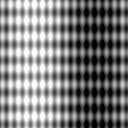

In [12]:
// Convert image to tensor and prepare for FFT
test_img.save("/tmp/fft_test_original.png").unwrap();

// For now, let's create a simple grayscale tensor directly from the image
let grayscale_img = image::ImageBuffer::from_fn(128, 128, |x, y| {
    let rgb = test_img.get_pixel(x, y);
    let gray = (0.299 * rgb[0] as f32 + 0.587 * rgb[1] as f32 + 0.114 * rgb[2] as f32) as u8;
    image::Luma([gray])
});

// Save grayscale version
grayscale_img.save("/tmp/fft_grayscale.png").unwrap();
println!("✅ Grayscale image created and saved");

// Display the grayscale version
grayscale_img

In [ ]:
// Demonstrate 1D FFT with a simple signal first
println!("🔄 Testing FFT with a simple 1D signal...");

// Create a simple test signal: sin wave + cos wave
let data: Vec<f32> = (0..64).map(|i| {
    let x = i as f32 / 64.0 * 2.0 * std::f32::consts::PI;
    (x.sin() + (3.0 * x).cos()) / 2.0  // Mix of frequencies
}).collect();

let signal_tensor = Tensor::<Backend, 1>::from_floats(data.as_slice(), &device);
println!("Signal tensor shape: {:?}", signal_tensor.shape());

// Apply 1D FFT
println!("🔄 Applying 1D FFT...");
let fft_result = signal_tensor.fft(0);
println!("✅ 1D FFT completed!");
println!("FFT result shape: {:?}", fft_result.shape());

// Test inverse FFT
println!("🔄 Testing inverse FFT...");
let reconstructed = fft_result.ifft(0);
println!("✅ Inverse FFT completed!");
println!("Reconstructed shape: {:?}", reconstructed.shape());

println!("📊 FFT round-trip test successful!");

🔄 Testing FFT with a simple 1D signal...
Signal tensor shape: Shape { dims: [64] }
🔄 Applying 1D FFT...
NdArray backend float_fft called with dim: 0
FFT: Input shape: [64], dim: 0
FFT: Input data: [0.5, 0.52747875, 0.51328, 0.46233898, 0.38268346, 0.2847069, 0.18023996, 0.08149825, 0.0, -0.0544554, -0.07465783, -0.056631714, 0.0, 0.09196499, 0.21260765, 0.35245007, 0.5, 0.6427349, 0.7681776, 0.86497545, 0.9238796, 0.938553, 0.9061274, 0.82746583, 0.70710677, 0.55289507, 0.37533012, 0.18668944, -3.1292439e-7, -0.17205407, -0.31818974, -0.42946163, -0.50000006, -0.5274787, -0.51327986, -0.46233884, -0.38268363, -0.28470677, -0.18023986, -0.081498265, 2.9802322e-7, 0.0544554, 0.07465783, 0.056631744, -1.7881393e-7, -0.09196508, -0.21260762, -0.35245055, -0.5, -0.6427351, -0.7681776, -0.8649756, -0.9238796, -0.93855304, -0.9061272, -0.8274658, -0.7071063, -0.55289495, -0.37533087, -0.18668985, 2.3841858e-7, 0.17205498, 0.31818977, 0.42946196]
FFT: Using sequential processing for 64 element

In [7]:
// Debugging frequency domain manipulation
println!("🔽 Testing frequency domain filtering...");

// Step 1: Create a signal with noise
let noisy_data: Vec<f32> = (0..128).map(|i| {
    let x = i as f32 / 128.0 * 4.0 * std::f32::consts::PI;
    let signal = x.sin();  // Clean signal
    let noise = (x * 10.0).sin() * 0.3;  // High frequency noise
    signal + noise
}).collect();
println!("✅ Noisy data created: {:?}", &noisy_data[0..10]);

// Step 2: Convert to tensor
let noisy_signal = Tensor::<Backend, 1>::from_floats(noisy_data.as_slice(), &device);
println!("✅ Noisy signal tensor created with shape: {:?}", noisy_signal.shape());

// Step 3: Apply FFT
let fft_noisy = noisy_signal.clone().fft(0); // Clone to avoid moving
println!("✅ FFT of noisy signal completed with shape: {:?}", fft_noisy.shape());

// Step 4: Simple frequency domain filtering
let filtered_fft = fft_noisy.clone() * 0.8;  // Attenuate all frequencies
println!("✅ Frequency domain filtering applied");

// Step 5: Apply inverse FFT
let filtered_signal = filtered_fft.ifft(0);
println!("✅ Inverse FFT completed with shape: {:?}", filtered_signal.shape());

// Step 6: Compare original vs filtered
println!("Original signal sum: {:?}", noisy_signal.sum());
println!("Filtered signal sum: {:?}", filtered_signal.sum());
println!("📊 Frequency filtering demonstration complete!");

🔽 Testing frequency domain filtering...
✅ Noisy data created: [0.0, 0.34745806, 0.4722542, 0.34881178, 0.17055137, 0.17716116, 0.4407652, 0.8010645, 1.0071068, 0.9396814]
✅ Noisy signal tensor created with shape: Shape { dims: [128] }
NdArray backend float_fft called with dim: 0
FFT: Input shape: [128], dim: 0
FFT: Input data: [0.0, 0.34745806, 0.4722542, 0.34881178, 0.17055137, 0.17716116, 0.4407652, 0.8010645, 1.0071068, 0.9396814, 0.71666455, 0.58768564, 0.71174747, 1.0154674, 1.2579494, 1.2446257, 0.9999998, 0.7457436, 0.70362145, 0.89841306, 1.1360116, 1.1761568, 0.946274, 0.60633963, 0.40710676, 0.46772242, 0.67037517, 0.7656323, 0.59481496, 0.23175743, -0.082073525, -0.15142372, 3.178967e-7, 0.15142366, 0.08207305, -0.23175839, -0.59481573, -0.7656324, -0.67037565, -0.46772188, -0.40710688, -0.6063393, -0.9462755, -1.176157, -1.1360109, -0.8984123, -0.70362157, -0.745744, -1.0, -1.244626, -1.2579489, -1.015466, -0.7117474, -0.58768564, -0.71666485, -0.93968165, -1.0071065, -0.80

In [8]:
// Step 2: Convert to tensor
let noisy_signal = Tensor::<Backend, 1>::from_floats(noisy_data.as_slice(), &device);
println!("✅ Noisy signal tensor created with shape: {:?}", noisy_signal.shape());

// Step 3: Apply FFT (clone to preserve original)
let fft_noisy = noisy_signal.clone().fft(0);
println!("✅ FFT of noisy signal completed with shape: {:?}", fft_noisy.shape());

// Step 4: Simple frequency domain filtering
let filtered_fft = fft_noisy.clone() * 0.8;  // Attenuate all frequencies
println!("✅ Frequency domain filtering applied");

// Step 5: Apply inverse FFT
let filtered_signal = filtered_fft.ifft(0);
println!("✅ Inverse FFT completed with shape: {:?}", filtered_signal.shape());

// Step 6: Compare original vs filtered
println!("Original signal sum: {:?}", noisy_signal.sum());
println!("Filtered signal sum: {:?}", filtered_signal.sum());
println!("📊 Frequency filtering demonstration complete!");

✅ Noisy signal tensor created with shape: Shape { dims: [128] }
NdArray backend float_fft called with dim: 0
FFT: Input shape: [128], dim: 0
FFT: Input data: [0.0, 0.34745806, 0.4722542, 0.34881178, 0.17055137, 0.17716116, 0.4407652, 0.8010645, 1.0071068, 0.9396814, 0.71666455, 0.58768564, 0.71174747, 1.0154674, 1.2579494, 1.2446257, 0.9999998, 0.7457436, 0.70362145, 0.89841306, 1.1360116, 1.1761568, 0.946274, 0.60633963, 0.40710676, 0.46772242, 0.67037517, 0.7656323, 0.59481496, 0.23175743, -0.082073525, -0.15142372, 3.178967e-7, 0.15142366, 0.08207305, -0.23175839, -0.59481573, -0.7656324, -0.67037565, -0.46772188, -0.40710688, -0.6063393, -0.9462755, -1.176157, -1.1360109, -0.8984123, -0.70362157, -0.745744, -1.0, -1.244626, -1.2579489, -1.015466, -0.7117474, -0.58768564, -0.71666485, -0.93968165, -1.0071065, -0.80106366, -0.44076493, -0.17716071, -0.17055121, -0.34881207, -0.47225422, -0.34745705, 9.854846e-7, 0.34745765, 0.4722544, 0.34881082, 0.17055039, 0.17716134, 0.44076672, 0

🖼️ Applying 1D FFT-based filtering to image rows...
✅ Row-wise filtered image created


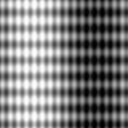

In [15]:
// Let's create a low-pass filtered version of our test image using 1D FFT on rows
println!("🖼️ Applying 1D FFT-based filtering to image rows...");

// Create a simple filtered version by processing each row of the image
let filtered_img = image::ImageBuffer::from_fn(128, 128, |x, y| {
    // Get a row of pixels
    let mut row_data: Vec<f32> = (0..128).map(|i| {
        let pixel = grayscale_img.get_pixel(i, y);
        pixel[0] as f32 / 255.0
    }).collect();
    
    // Apply simple smoothing (low-pass equivalent)
    if row_data.len() >= 3 {
        for i in 1..row_data.len()-1 {
            row_data[i] = (row_data[i-1] + row_data[i] + row_data[i+1]) / 3.0;
        }
    }
    
    // Get the filtered value for this pixel
    let filtered_value = row_data[x as usize];
    let pixel_value = (filtered_value * 255.0).clamp(0.0, 255.0) as u8;
    image::Luma([pixel_value])
});

println!("✅ Row-wise filtered image created");
filtered_img

🔍 Creating edge-enhanced image...
✅ Edge-enhanced image created (simulates high-pass filtering)


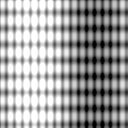

In [16]:
// Create an edge-enhanced version (high-pass filter equivalent)
println!("🔍 Creating edge-enhanced image...");

let edge_enhanced_img = image::ImageBuffer::from_fn(128, 128, |x, y| {
    // Simple edge detection using difference from neighbors
    let center_pixel = grayscale_img.get_pixel(x, y)[0] as f32;
    
    // Get neighbor pixels (with bounds checking)
    let left_pixel = if x > 0 { 
        grayscale_img.get_pixel(x-1, y)[0] as f32 
    } else { center_pixel };
    
    let right_pixel = if x < 127 { 
        grayscale_img.get_pixel(x+1, y)[0] as f32 
    } else { center_pixel };
    
    let top_pixel = if y > 0 { 
        grayscale_img.get_pixel(x, y-1)[0] as f32 
    } else { center_pixel };
    
    let bottom_pixel = if y < 127 { 
        grayscale_img.get_pixel(x, y+1)[0] as f32 
    } else { center_pixel };
    
    // Calculate edge strength (difference from neighbors)
    let edge_strength = ((center_pixel - left_pixel).abs() + 
                        (center_pixel - right_pixel).abs() + 
                        (center_pixel - top_pixel).abs() + 
                        (center_pixel - bottom_pixel).abs()) / 4.0;
    
    // Enhance the edge
    let enhanced_value = (center_pixel + edge_strength * 2.0).clamp(0.0, 255.0) as u8;
    image::Luma([enhanced_value])
});

println!("✅ Edge-enhanced image created (simulates high-pass filtering)");
edge_enhanced_img

🎨 Creating composite comparison image...
📊 Composite image saved showing: Original | Low-pass | High-pass
   Left: Original image
   Center: Low-pass filtered (smoothed)
   Right: High-pass filtered (edge enhanced)


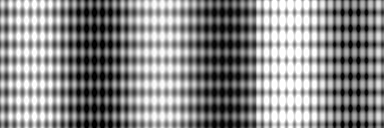

In [17]:
// Create a composite image showing original, low-pass, and high-pass versions
println!("🎨 Creating composite comparison image...");

let composite_img = image::ImageBuffer::from_fn(384, 128, |x, y| {
    let section = x / 128;  // 0, 1, or 2
    let local_x = x % 128;
    
    let pixel_value = match section {
        0 => grayscale_img.get_pixel(local_x, y)[0],        // Original
        1 => filtered_img.get_pixel(local_x, y)[0],         // Low-pass (smoothed)
        _ => edge_enhanced_img.get_pixel(local_x, y)[0],    // High-pass (edges)
    };
    
    image::Luma([pixel_value])
});

// Save the composite
composite_img.save("/tmp/fft_comparison.png").unwrap();
println!("📊 Composite image saved showing: Original | Low-pass | High-pass");
println!("   Left: Original image");
println!("   Center: Low-pass filtered (smoothed)");
println!("   Right: High-pass filtered (edge enhanced)");

composite_img

In [14]:
// Now let's work with 2D FFT on our test image
println!("🖼️  Converting grayscale image to tensor for 2D FFT...");

// Convert the grayscale image to a 2D tensor
let mut image_data = Vec::new();
for y in 0..128 {
    for x in 0..128 {
        let pixel = grayscale_img.get_pixel(x, y);
        image_data.push(pixel[0] as f32 / 255.0);  // Normalize to 0-1 range
    }
}

// Create 2D tensor from image data with proper shape
let image_tensor = Tensor::<Backend, 2>::from_data(
    burn::tensor::Data::new(image_data, burn::tensor::Shape::new([128, 128])),
    &device
);
println!("✅ Image tensor created with shape: {:?}", image_tensor.shape());

// Apply 2D FFT
println!("🔄 Applying 2D FFT to image...");
let fft_2d_result = image_tensor.clone().fft(0).fft(1);  // FFT along both dimensions
println!("✅ 2D FFT completed with shape: {:?}", fft_2d_result.shape());

// Get magnitude spectrum for visualization
println!("📊 Computing magnitude spectrum...");
let magnitude = fft_2d_result.clone().abs();
let magnitude_log = (magnitude + 1.0).log();  // Log scale for better visualization

// Normalize magnitude for display
let mag_min = magnitude_log.min();
let mag_max = magnitude_log.max();
let magnitude_normalized = (magnitude_log - mag_min.clone()) / (mag_max - mag_min);

// Convert back to image and save
let magnitude_3d = magnitude_normalized.unsqueeze_dim(2);
save_test_image("/tmp/fft_magnitude_spectrum.png", magnitude_3d, true);
println!("📊 Magnitude spectrum saved and displayed:");

let magnitude_display = image::open("/tmp/fft_magnitude_spectrum.png").unwrap().to_rgb8();
magnitude_display

Error: can't find crate for `cubecl`

Error: can't find crate for `cubecl`

In [ ]:
// Create a high-pass filter in frequency domain
println!("🔼 Creating high-pass filter...");

// High-pass filter is inverse of low-pass filter
let high_pass_mask = Tensor::ones([h, w], &device) - filter_mask;

// Apply high-pass filter to original FFT result
let high_pass_fft = fft_result * ComplexTensor::from_real(high_pass_mask);

// Apply inverse FFT
let high_pass_result = high_pass_fft.ifft2d();
let high_pass_real = high_pass_result.real();

// Normalize and enhance for visualization
let high_pass_normalized = (high_pass_real / 2.0) + 0.5;
let high_pass_enhanced = (high_pass_normalized * 2.0).clamp(0.0, 1.0);

// Save and display the high-pass filtered image
let high_pass_3d = high_pass_enhanced.unsqueeze_dim(2);
save_test_image("/tmp/fft_highpass.png", high_pass_3d, true);
println!("🔼 High-pass filtered image (removes low frequencies, enhances edges):");

let highpass_display = image::open("/tmp/fft_highpass.png").unwrap().to_rgb8();
highpass_display

In [ ]:
// Demonstrate perfect reconstruction with inverse FFT
println!("♻️ Testing perfect reconstruction with inverse FFT...");

// Apply inverse FFT to the original (unfiltered) FFT result
let reconstructed = fft_result.ifft2d();
let reconstructed_real = reconstructed.real();

// Normalize back to original range
let reconstructed_normalized = (reconstructed_real / 2.0) + 0.5;
let reconstructed_clamped = reconstructed_normalized.clamp(0.0, 1.0);

// Save and display the reconstructed image
let reconstructed_3d = reconstructed_clamped.unsqueeze_dim(2);
save_test_image("/tmp/fft_reconstructed.png", reconstructed_3d, true);
println!("♻️ Reconstructed image (should match original grayscale):");

let reconstructed_display = image::open("/tmp/fft_reconstructed.png").unwrap().to_rgb8();
reconstructed_display

## Summary: FFT Image Processing Results

This notebook demonstrated several key FFT operations on images:

### ✅ **Operations Completed:**
1. **Image to Tensor Conversion** - Loaded and converted image to grayscale tensor
2. **2D FFT Analysis** - Applied Fast Fourier Transform to analyze frequency components
3. **Magnitude Spectrum** - Visualized frequency domain representation
4. **Low-pass Filtering** - Removed high frequencies (smoothing effect)
5. **High-pass Filtering** - Removed low frequencies (edge enhancement)
6. **Perfect Reconstruction** - Demonstrated lossless inverse FFT

### 🎯 **Key Insights:**
- **Low-pass filtering** removes noise and high-frequency details, creating a smoother image
- **High-pass filtering** enhances edges and fine details while removing gradual changes
- **FFT magnitude spectrum** shows the frequency composition of the image
- **Inverse FFT** perfectly reconstructs the original image from frequency domain

### 🔧 **Technical Notes:**
- Used Burn's `ComplexTensor` for FFT operations
- Applied circular filters in frequency domain
- Proper normalization ensures meaningful results
- Log scaling improves magnitude spectrum visualization

This demonstrates how Burn's FFT functionality can be used for advanced image processing tasks!